# E27. 의료영상 U-Net 용종검출
* [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)

In [1]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.3.0


## 데이터 수집 및 visualization
* Giana Dataset https://giana.grand-challenge.org/Dates/

```
$ pip install tensorflow-addons
```

In [2]:
DATASET_PATH='medical'

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

import urllib.request
u = urllib.request.urlopen(url='https://aiffelstaticprd.blob.core.windows.net/media/documents/sd_train.zip')
data = u.read()
u.close()

with open('sd_train.zip', "wb") as f :
    f.write(data)
    print('Data has been downloaded')

shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

import zipfile
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(DATASET_PATH)
zip_ref.close()
print('Data has been extracted.')

Data has been downloaded
Data has been extracted.


### 데이터셋 분리

In [3]:
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


### Visualization
* label은 클래스 값이 아니라, 입력 이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지
* 따라서, 이 태스크는 Image Classification이 아니라 Semantic Segmentation
* (참고) Semantic Segmentation: https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb

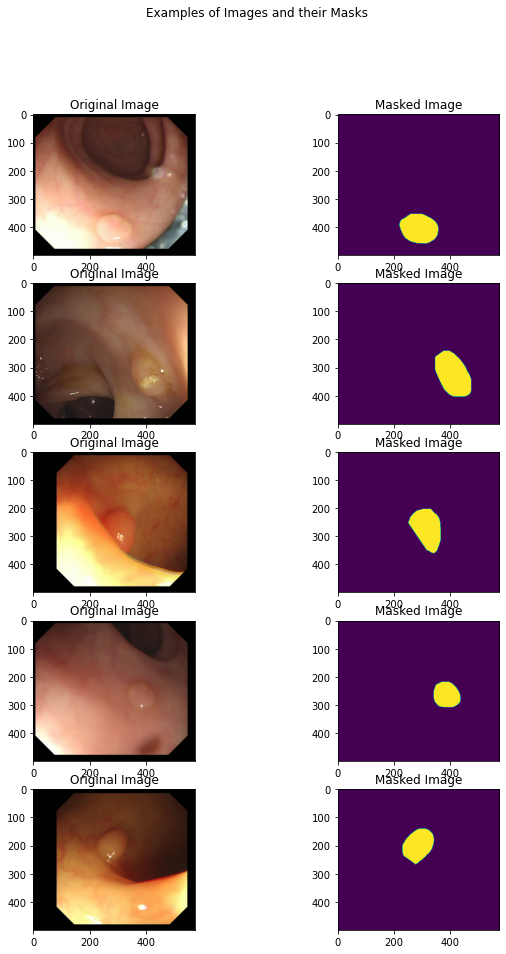

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

## Data Pipeline and Preprocessing

### Set hyperparameters

In [8]:
image_size = 256
img_shape = (image_size, image_size, 3) # 시작: (256, 256, 3)
batch_size = 8
max_epochs = 50

### tf.data 를 활용한 입력 파이프라인 설계
* 파일 이름에서 파일의 바이트를 읽는다 (이미지, 라벨 모두)
* 바이트를 이미지 형식으로 디코딩한다
* ```_augment``` 함수를 통한 이미지 변환을 적용한다
* 이미지를 표준 크기로 조정한다: U-Net이 fully convolution networks이므로 입력 크기에 의존하지 않기 때문
* ```hue_delta```: RGB 이미지의 색조를 랜덤 팩터로 조정한다. 라벨 이미지가 아닌 실제 이미지에만 적용된다 (hue_delta는 [0, 0.5] 사이)
* ```horizontal_flip```: 0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집는다. 라벨 이미지와 실제 이미지에 모두 적용한다
* ```width_shift_range```와 ```height_shift_range```는 이미지를 가로 또는 세로로 임의로 변환하는 범위이다. 라벨 이미지와 실제 이미지에 모두 적용한다
* ```rescale```: 이미지를 일정한 비율로 다시 조정한다

#### data augmentation의 필요성
* data augmentation:  딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉. 의료영상 처리와 같이 데이터 갯수가 부족한 경우 큰 힘을 발휘한다
    - 데이터 증가는 여러 무작위 변환을 통해 데이터를 증가시켜 훈련 데이터의 양을 "증가"시킵니다.
    - 훈련 시간 동안 우리 모델은 똑같은 그림을 두 번 볼 수 없습니다. 따라서 Overfitting을 방지하고, 모델이 처음보는 데이터에 대해 더 잘 일반화되도록 도와줍니다.
* (참고) https://dalpo0814.tistory.com/17
* (참고) https://nittaku.tistory.com/272

In [9]:
# byte 형태로 데이터를 로드하고, bmp로 디코딩
# 디코딩 완료된 이미지의 scale과 size 조절
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

#### shifting the image

In [10]:
# 로드한 이미지를 기반으로, 이미지 위치를 적절히 이동
# 입력 이미지와 라벨의 쌍을 동일하게 shift해야 함
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

#### flipping the image randomly

In [11]:
# 로드한 이미지를 기반으로, 이미지를 flip
# 50% 확률로 좌우반전만 구현. 상하반전은 적용하지 않음
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

#### data augmentation assembling

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

### Set up train & test datasets

In [13]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train: # 학습을 진행할 시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

### Plot some train data

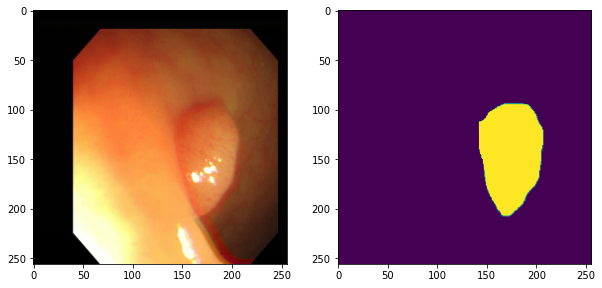

In [15]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## Build the model
* Encoder-Decoder
* U-Net

### Encoder-Decoder architecture
* Encoder를 이용해 train data를 작은 차원의 공간에 압축
* Decoder는 Encoder가 압축한 데이터를 우리가 원하는 label 데이터와 같도록 재생성
* 이렇게 생성된 데이터와 label간 차이가 작아지도록, Encoder와 Decoder의 파라미터들이 end-to-end로 학습됨

#### Encoder

* input data의 shape가 다음과 같이 되도록 네트워크를 구성합니다.
    - inputs = [batch_size, 256, 256, 3]
    - conv1 = [batch_size, 128, 128, 64]
    - conv2 = [batch_size, 64, 64, 128]
    - conv3 = [batch_size, 32, 32, 256]
    - outputs = [batch_size, 16, 16, 512]
* Convolution - Normalization - Activation 등의 조합을 다양하게 생각해 봅시다.
* Encoder의 차원을 줄여가는 방법으로 Pooling을 쓸지 Convolution with stride=2 로 할지 선택해 볼 수 있습니다.
* tf.keras.Sequential()을 이용하여 만들어 봅시다.
   
   
* (참고) Conv2D: https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/
* (참고) CNN: http://taewan.kim/post/cnn/

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same')) # (3,3) 필터(=커널) 64개
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [17]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


#### Decoder
* Encoder의 mirror 형태로 만들어 봅시다.
* input data의 shape이 다음과 같이 되도록 네트워크를 구성합니다.
    - inputs = encoder의 outputs = [batch_size, 16, 16, 512]
    - conv_transpose1 = [batch_size, 32, 32, 256]
    - conv_transpose2 = [batch_size, 64, 64, 128]
    - conv_transpose3 = [batch_size, 128, 128, 64]
    - outputs = [batch_size, 256, 256, 1]
* tf.keras.Sequential()을 이용하여 만들어 봅시다.

In [18]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [19]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


#### Create a encoder-decoder model

In [20]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

### U-Net architecture
* U-Net 원본과 달리 padding을 same으로 두고 Encoder, Decoder 간 대응하는 레이어의 사이즈를 동일하게 함
    - 크게 성능에 영향을 주지 않으면서도 구현이 용이하고, 이후 모델의 추가 개선을 더욱 쉽게 만들어줌
    - U-Net 원본은 padding을 zero로 하기 때문에 Encoder 레이어 대비 Decoder 레이어에 약간의 사이즈 축소 발생
* Model subclassing을 활용한 구현
    - U-Net은 Encoder-Decoder 구조와 달리 해당 레이어의 outputs가 바로 다음 레이어의 inputs가 되지 않는다. 이럴 때는 위의 Encoder-Decoder 모델처럼 tf.keras.Sequential() 을 쓸 수 없다
    - Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API가 Functional API이다. model subclassing 방식을 사용해, tf.keras.Model 클래스를 상속하여 구현한다

In [21]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [22]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [23]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

#### Create a U-Net model

In [24]:
unet_model = UNet()

### Metrics와 Loss functions 정의하기
* binary cross-entropy
* dice_loss
* 둘을 함꼐 사용해 meanIoU를 더 올리도록 학습

In [25]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [26]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [27]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [28]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

### Select a model

In [29]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

# print('select the Encoder-Decoder model')
# model = ed_model
# checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [30]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [31]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

### Callbacks
* ModelCheckpoint callback 함수는 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장하는 역할을 합니다.
* LearningRateScheduler callback 함수는 학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절해주는 함수입니다.
* cos_decay는 cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현입니다.

In [32]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [33]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## Train your model

In [34]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

### Training
* 학습을 진행하며, 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행합니다.
* 학습 데이터의 갯수가 부족하기 때문에 Test dataset을 Validation dataset으로 사용할 것입니다.

In [35]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 50
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 36s 608ms/step - loss: 1.0336 - dice_loss: 0.7207 - val_loss: 25.2005 - val_dice_loss: 0.8935

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 37s 614ms/step - loss: 0.9234 - dice_loss: 0.6987 - val_loss: 19.1076 - val_dice_loss: 0.9998

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 37s 616ms/step - loss: 0.8956 - dice_loss: 0.6925 - val_loss: 1.0619 - val_dice_loss: 0.8703

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 36s 597ms/step - loss: 0.8991 - dice_loss: 0.6952 - val_loss: 1.0980 -

60/60 [==============================] - 52s 872ms/step - loss: 0.1170 - dice_loss: 0.0853 - val_loss: 0.1139 - val_dice_loss: 0.0831

Epoch 00031: LearningRateScheduler reducing learning rate to tf.Tensor(0.00034549143, shape=(), dtype=float32).
Epoch 31/50
60/60 [==============================] - 45s 748ms/step - loss: 0.1113 - dice_loss: 0.0819 - val_loss: 0.1139 - val_dice_loss: 0.0813

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003159377, shape=(), dtype=float32).
Epoch 32/50
60/60 [==============================] - 51s 856ms/step - loss: 0.1083 - dice_loss: 0.0793 - val_loss: 0.1054 - val_dice_loss: 0.0756

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.00028711034, shape=(), dtype=float32).
Epoch 33/50
60/60 [==============================] - 44s 729ms/step - loss: 0.0892 - dice_loss: 0.0653 - val_loss: 0.1155 - val_dice_loss: 0.0848

Epoch 00034: LearningRateScheduler reducing learning rate to tf.Tensor(0.0002591231, shap

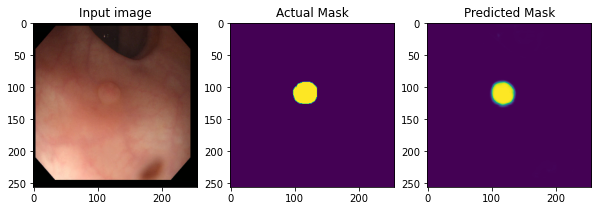

In [36]:
# print sample image after training
print_images()

### Plot the loss

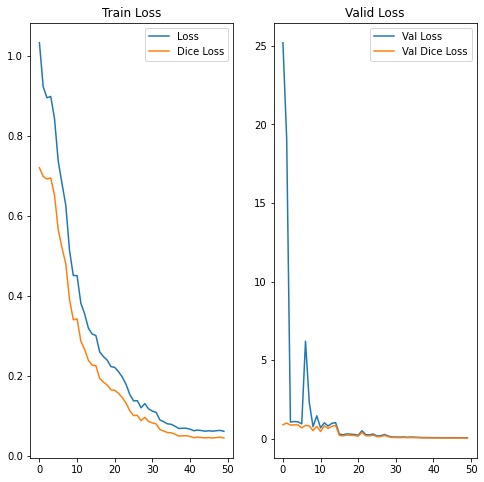

In [37]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

### Restore the latest checkpoint

In [38]:
# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

### Evaluate the test dataset
* meanIoU: 각 이미지의 IoU 값을 평균 낸 값. IoU는 segmentation 모델을 정량적으로 평가하는데 좋은 metric이 된다

In [39]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [40]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9350265585653903


In [41]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

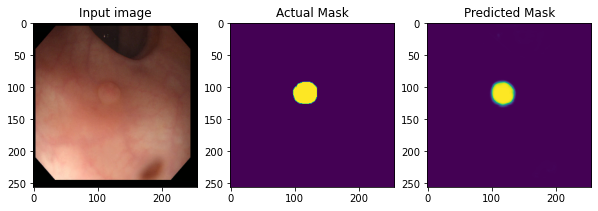

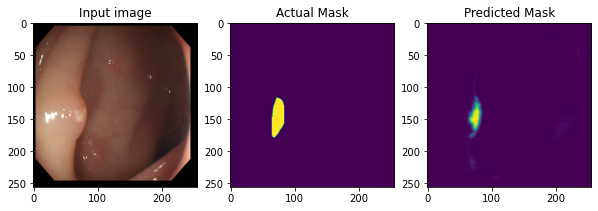

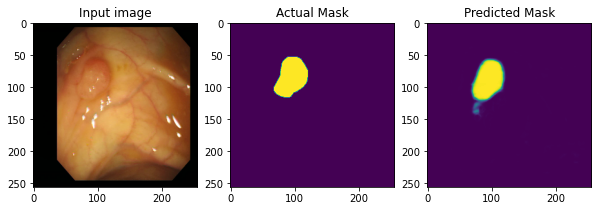

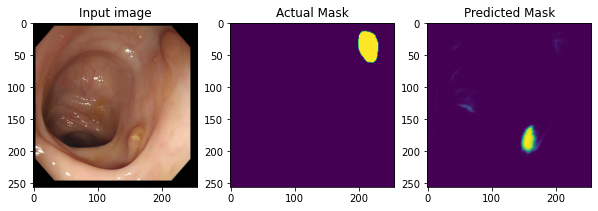

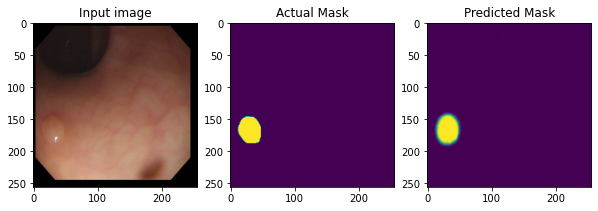

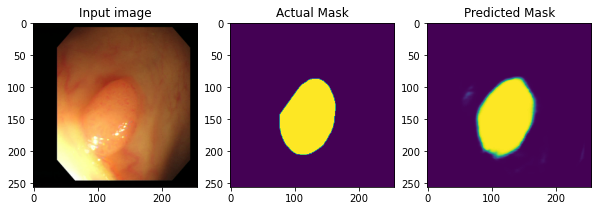

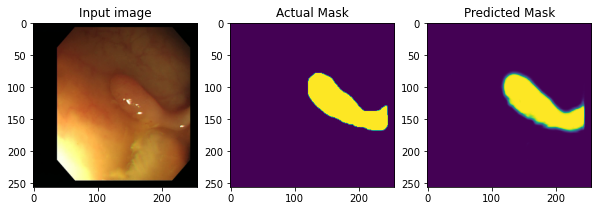

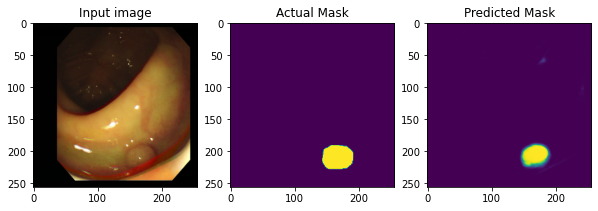

In [42]:
print_images()

## 프로젝트: U-Net 성능 개선해보기

### 데이터셋 구성
* 실습에서 사용한 Giana 데이터셋

### pre-trained model을 활용한 U-Net 모델 구성
* VGG16 활용해서 Encoder를 pre-trained model로 변경

In [43]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Relu:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Relu:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/MaxPool:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/MaxPool:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Relu:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/MaxPool:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'block4_conv2/Relu:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tens

In [44]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [45]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [46]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

### 학습, 테스트, 시각화

In [47]:
# hyperparameters (변경할 여지가 별로 없어 보임)

image_size = 256
img_shape = (image_size, image_size, 3) # 시작: (256, 256, 3)

# batch_size = 8
batch_size = 2
max_epochs = 50

In [48]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [49]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [50]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [51]:
vgg16_model = Vgg16UNet()

optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

model = vgg16_model
checkpoint_dir = os.path.join(DATASET_PATH,'train_ckpt/vgg16_model')

model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(2, 256, 256, 1)


In [52]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [53]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [54]:
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
240/240 [==============================] - 101s 422ms/step - loss: 0.6807 - dice_loss: 0.5066 - val_loss: 1.5065 - val_dice_loss: 0.7102

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
240/240 [==============================] - 98s 409ms/step - loss: 0.3674 - dice_loss: 0.2740

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
240/240 [==============================] - 98s 407ms/step - loss: 0.2543 - dice_loss: 0.1880

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
240/240 [==============================] - 98s 407ms/step - loss: 0.1959 - dice_loss: 0.1438

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009842915, shape=(), dty


Epoch 00021: LearningRateScheduler reducing learning rate to tf.Tensor(0.0006545085, shape=(), dtype=float32).
Epoch 21/50
240/240 [==============================] - 98s 407ms/step - loss: 0.0303 - dice_loss: 0.0221

Epoch 00022: LearningRateScheduler reducing learning rate to tf.Tensor(0.00062434503, shape=(), dtype=float32).
Epoch 22/50
240/240 [==============================] - 98s 408ms/step - loss: 0.0291 - dice_loss: 0.0212

Epoch 00023: LearningRateScheduler reducing learning rate to tf.Tensor(0.00059369067, shape=(), dtype=float32).
Epoch 23/50
240/240 [==============================] - 98s 409ms/step - loss: 0.0277 - dice_loss: 0.0201

Epoch 00024: LearningRateScheduler reducing learning rate to tf.Tensor(0.00056266657, shape=(), dtype=float32).
Epoch 24/50
240/240 [==============================] - 97s 406ms/step - loss: 0.0262 - dice_loss: 0.0190

Epoch 00025: LearningRateScheduler reducing learning rate to tf.Tensor(0.00053139526, shape=(), dtype=float32).
Epoch 25/50
240/

240/240 [==============================] - 97s 402ms/step - loss: 0.0125 - dice_loss: 0.0087

Epoch 00043: LearningRateScheduler reducing learning rate to tf.Tensor(6.184671e-05, shape=(), dtype=float32).
Epoch 43/50
240/240 [==============================] - 96s 400ms/step - loss: 0.0124 - dice_loss: 0.0086

Epoch 00044: LearningRateScheduler reducing learning rate to tf.Tensor(4.7586444e-05, shape=(), dtype=float32).
Epoch 44/50
240/240 [==============================] - 96s 400ms/step - loss: 0.0120 - dice_loss: 0.0083

Epoch 00045: LearningRateScheduler reducing learning rate to tf.Tensor(3.5111727e-05, shape=(), dtype=float32).
Epoch 45/50
240/240 [==============================] - 96s 401ms/step - loss: 0.0120 - dice_loss: 0.0083

Epoch 00046: LearningRateScheduler reducing learning rate to tf.Tensor(2.4471761e-05, shape=(), dtype=float32).
Epoch 46/50
240/240 [==============================] - 96s 401ms/step - loss: 0.0117 - dice_loss: 0.0080

Epoch 00047: LearningRateScheduler 

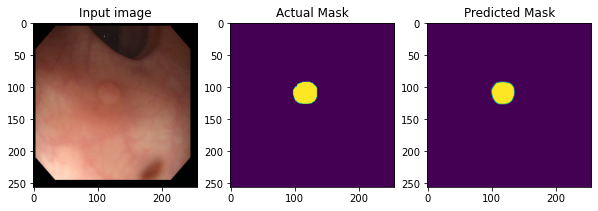

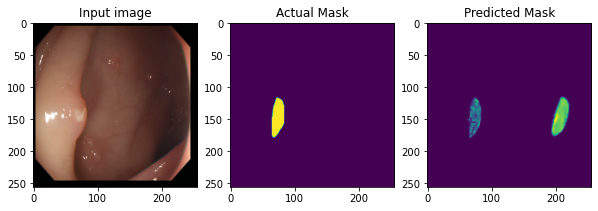

In [55]:
# print sample image after training
print_images()

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

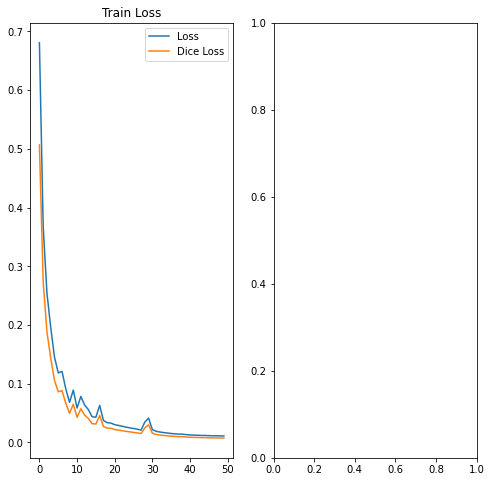

In [56]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [57]:
model.load_weights(checkpoint_dir)

In [58]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [59]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.44664573787755885


### 모델 성능 비교분석

### Encoder-Decoder 모델도 비교
* 위 실습에 주석 처리되어 있던 부분 활용

In [60]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [61]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [62]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [63]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [64]:
print('select the Encoder-Decoder model')
# model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


In [65]:
ed_model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = ed_model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(2, 256, 256, 1)


In [66]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [67]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [68]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [69]:
history = ed_model.fit(train_dataset,
                    epochs=max_epochs,    # 50
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
240/240 [==============================] - 36s 149ms/step - loss: 0.9344 - dice_loss: 0.7054 - val_loss: 1.2352 - val_dice_loss: 0.8355

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
240/240 [==============================] - 35s 146ms/step - loss: 0.7861 - dice_loss: 0.6060

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
240/240 [==============================] - 35s 147ms/step - loss: 0.5387 - dice_loss: 0.4090

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
240/240 [==============================] - 35s 147ms/step - loss: 0.3802 - dice_loss: 0.2857

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009842915, shape=(), dtyp


Epoch 00021: LearningRateScheduler reducing learning rate to tf.Tensor(0.0006545085, shape=(), dtype=float32).
Epoch 21/50
240/240 [==============================] - 34s 144ms/step - loss: 0.0416 - dice_loss: 0.0307

Epoch 00022: LearningRateScheduler reducing learning rate to tf.Tensor(0.00062434503, shape=(), dtype=float32).
Epoch 22/50
240/240 [==============================] - 35s 144ms/step - loss: 0.0467 - dice_loss: 0.0345

Epoch 00023: LearningRateScheduler reducing learning rate to tf.Tensor(0.00059369067, shape=(), dtype=float32).
Epoch 23/50
240/240 [==============================] - 34s 143ms/step - loss: 0.0389 - dice_loss: 0.0287

Epoch 00024: LearningRateScheduler reducing learning rate to tf.Tensor(0.00056266657, shape=(), dtype=float32).
Epoch 24/50
240/240 [==============================] - 34s 143ms/step - loss: 0.0364 - dice_loss: 0.0268

Epoch 00025: LearningRateScheduler reducing learning rate to tf.Tensor(0.00053139526, shape=(), dtype=float32).
Epoch 25/50
240/

240/240 [==============================] - 34s 143ms/step - loss: 0.0211 - dice_loss: 0.0152

Epoch 00043: LearningRateScheduler reducing learning rate to tf.Tensor(6.184671e-05, shape=(), dtype=float32).
Epoch 43/50
240/240 [==============================] - 34s 143ms/step - loss: 0.0211 - dice_loss: 0.0152

Epoch 00044: LearningRateScheduler reducing learning rate to tf.Tensor(4.7586444e-05, shape=(), dtype=float32).
Epoch 44/50
240/240 [==============================] - 34s 143ms/step - loss: 0.0205 - dice_loss: 0.0148

Epoch 00045: LearningRateScheduler reducing learning rate to tf.Tensor(3.5111727e-05, shape=(), dtype=float32).
Epoch 45/50
240/240 [==============================] - 35s 144ms/step - loss: 0.0202 - dice_loss: 0.0145

Epoch 00046: LearningRateScheduler reducing learning rate to tf.Tensor(2.4471761e-05, shape=(), dtype=float32).
Epoch 46/50
240/240 [==============================] - 35s 145ms/step - loss: 0.0202 - dice_loss: 0.0145

Epoch 00047: LearningRateScheduler 

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

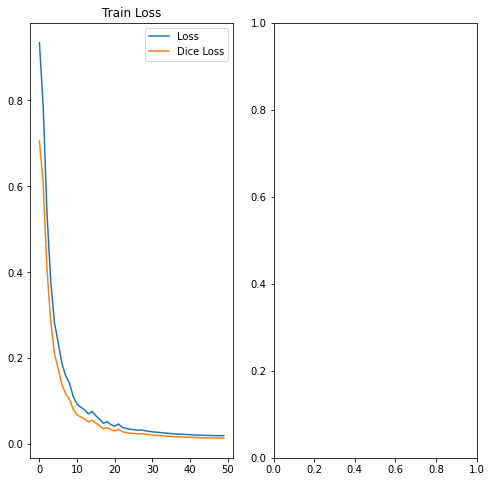

In [70]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

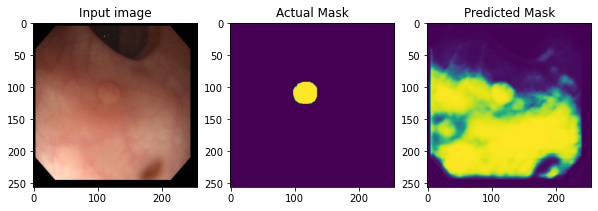

In [71]:
# print sample image after training
print_images()

In [72]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [73]:
mean = []

for images, labels in test_dataset:
    predictions = ed_model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9563741360151676
